In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00


In [2]:
!pip install matplotlib-venn

In [3]:
!pip install langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.3 MB/s eta 0:00:00


In [6]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [8]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings # Import OpenAIEmbeddings

# Initialize embeddings object
embeddings = OpenAIEmbeddings()

vector_store = InMemoryVectorStore(embeddings)

In [23]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Filtro para extraer títulos y contenido de la documentación de Python
bs4_strainer = bs4.SoupStrainer(["h1", "h2", "h3", "div"])
loader = WebBaseLoader(
    web_paths=("https://docs.python.org/3/tutorial/index.html",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

# Verificar que se cargó al menos un documento
assert len(docs) == 1

# Mostrar el contenido extraído
print(f"Total characters: {len(docs[0].page_content)}")
print("Contenido extraído:")
print(docs[0].page_content)

Total characters: 7255
Contenido extraído:
























    Theme
    
Auto
Light
Dark



Previous topic
Changelog


Next topic
1. Whetting Your Appetite


This Page

Report a Bug

Show Source
        






Navigation


index

modules |

next |

previous |

Python »







3.13.2 Documentation »
    
The Python Tutorial







                     |
                


    Theme
    
Auto
Light
Dark

 |






The Python Tutorial¶
Python is an easy to learn, powerful programming language. It has efficient
high-level data structures and a simple but effective approach to
object-oriented programming. Python’s elegant syntax and dynamic typing,
together with its interpreted nature, make it an ideal language for scripting
and rapid application development in many areas on most platforms.
The Python interpreter and the extensive standard library are freely available
in source or binary form for all major platforms from the Python web site,
https://www.python.org/, and may be freel

In [24]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 10 sub-documents.


In [25]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['79ce3120-2b9a-44fa-a791-8a674f957099', '3b50f531-68cd-4cbf-bd66-5afabc67f646', 'a32f92e0-c06b-4cc7-809c-56fde686d2dc']


In [26]:
from langchain import hub


prompt = hub.pull("rlm/rag-prompt")

context = "El aprendizaje automático es una rama de la inteligencia artificial que se enfoca en desarrollar algoritmos que pueden aprender de los datos."
question = "¿Qué es el aprendizaje automático?"

example_messages = prompt.invoke(
    {"context": context, "question": question}
).to_messages()

assert len(example_messages) == 1

print("Mensaje generado:")
print(example_messages[0].content)

Mensaje generado:
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: ¿Qué es el aprendizaje automático? 
Context: El aprendizaje automático es una rama de la inteligencia artificial que se enfoca en desarrollar algoritmos que pueden aprender de los datos. 
Answer:


In [27]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")

response = llm.invoke(example_messages[0].content)

print("Respuesta generada:")
print(response.content)

Respuesta generada:
El aprendizaje automático es una disciplina dentro de la inteligencia artificial que se centra en crear algoritmos capaces de aprender de los datos proporcionados.


In [28]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# Definir la estructura de datos tipada
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [29]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

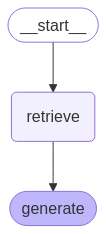

In [35]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# Construir el grafo de flujo de trabajo
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

# Visualizar el grafo
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
# Definir el estado inicial
state: State = {
    "question": "¿Qué es Python?",
    "context": [],
    "answer": ""
}

# Paso 1: Recuperar documentos relevantes
state.update(retrieve(state))

# Paso 2: Generar una respuesta
state.update(generate(state))

# Mostrar el estado final
print("Estado final:")
print(state)

Estado final:
{'question': '¿Qué es Python?', 'context': [Document(id='3b50f531-68cd-4cbf-bd66-5afabc67f646', metadata={'source': 'https://docs.python.org/3/tutorial/index.html', 'start_index': 381}, page_content='The Python Tutorial¶\nPython is an easy to learn, powerful programming language. It has efficient\nhigh-level data structures and a simple but effective approach to\nobject-oriented programming. Python’s elegant syntax and dynamic typing,\ntogether with its interpreted nature, make it an ideal language for scripting\nand rapid application development in many areas on most platforms.\nThe Python interpreter and the extensive standard library are freely available\nin source or binary form for all major platforms from the Python web site,\nhttps://www.python.org/, and may be freely distributed. The same site also\ncontains distributions of and pointers to many free third party Python modules,\nprograms and tools, and additional documentation.\nThe Python interpreter is easily ex

In [37]:
# Definir el estado inicial
state: State = {
    "question": "¿Qué es Python?",
    "context": [],
    "answer": ""
}

# Ejecutar el grafo
state = graph.invoke(state)

# Mostrar el estado final
print("Estado final:")
print(state)

Estado final:
{'question': '¿Qué es Python?', 'context': [Document(id='3b50f531-68cd-4cbf-bd66-5afabc67f646', metadata={'source': 'https://docs.python.org/3/tutorial/index.html', 'start_index': 381}, page_content='The Python Tutorial¶\nPython is an easy to learn, powerful programming language. It has efficient\nhigh-level data structures and a simple but effective approach to\nobject-oriented programming. Python’s elegant syntax and dynamic typing,\ntogether with its interpreted nature, make it an ideal language for scripting\nand rapid application development in many areas on most platforms.\nThe Python interpreter and the extensive standard library are freely available\nin source or binary form for all major platforms from the Python web site,\nhttps://www.python.org/, and may be freely distributed. The same site also\ncontains distributions of and pointers to many free third party Python modules,\nprograms and tools, and additional documentation.\nThe Python interpreter is easily ex

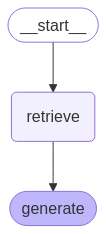

In [38]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))